# Descripción del proyecto

La compañía Sweet Lift Taxi, es una compañia dedicada al servicio de taxis en los aeropuestos, y está buscando conocer los horarios dónde se concentran el mayor número de pedidos de servicio, para así poder mejorar su logística de personal. 

# Objetivo


Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Se construye un modelo para dicha predicción, cuya métrica RECM en el conjunto de prueba no es superior a 48.


# Recursos

Sweet Lift Taxi nos proporciona la siguiente información:

    - recopilación de datos históricos sobre pedidos de taxis


## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Carga y revisión de los datos

In [1]:
# Carga de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer 

from sklearn.linear_model import LinearRegression   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Carga del archivo csv

df = pd.read_csv('/datasets/taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
display(df)
print(f'\nEl número total de filas duplicadas en este archivo es de {df.duplicated().sum()} filas.')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27



El número total de filas duplicadas en este archivo es de 26415 filas.


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
print('Rango de fechas:', df.index.min(), 'a', df.index.max())

Rango de fechas: 2018-03-01 00:00:00 a 2018-08-31 23:50:00


En la revisión de los datos tenemos la siguiente información:

| Nombre de columna | Característica | Tipo de dato | Datos Nulos | Min | Max |
|-------------------|----------------|--------------|-------------|-------------|-------------|
| datetime | Fecha 'yyyy-mm-dd hh:mm:ss' | se convierte a tipo datetime64 | 0 | 2018-03-01 00:00:00 | 2018-08-31 23:50:00 |
| num_orders | cantidad de servicios solicitados | int64 | 0 | 0 | 119 |

    - La información del tiempo viene dado en rangos de 10 minutos.
    - Los datos van del 01 de marzo al 31 de agosto del 2023.
    - No hay datos duplicados ni nulos.
    - El máximo de servicios solicitados en 10 minutos es de 119 servicios


## Preparación y análisis

In [7]:
# Revisar si el indice está en órden cronológico
df.index.is_monotonic

True

Debido a que lo que se quiere conocer sobre 'horas pico', se hace un re-muestreo a cada hora

In [8]:
df = df.resample('1H').sum().sort_index()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Se analiza las tendencias y la estacionalidad

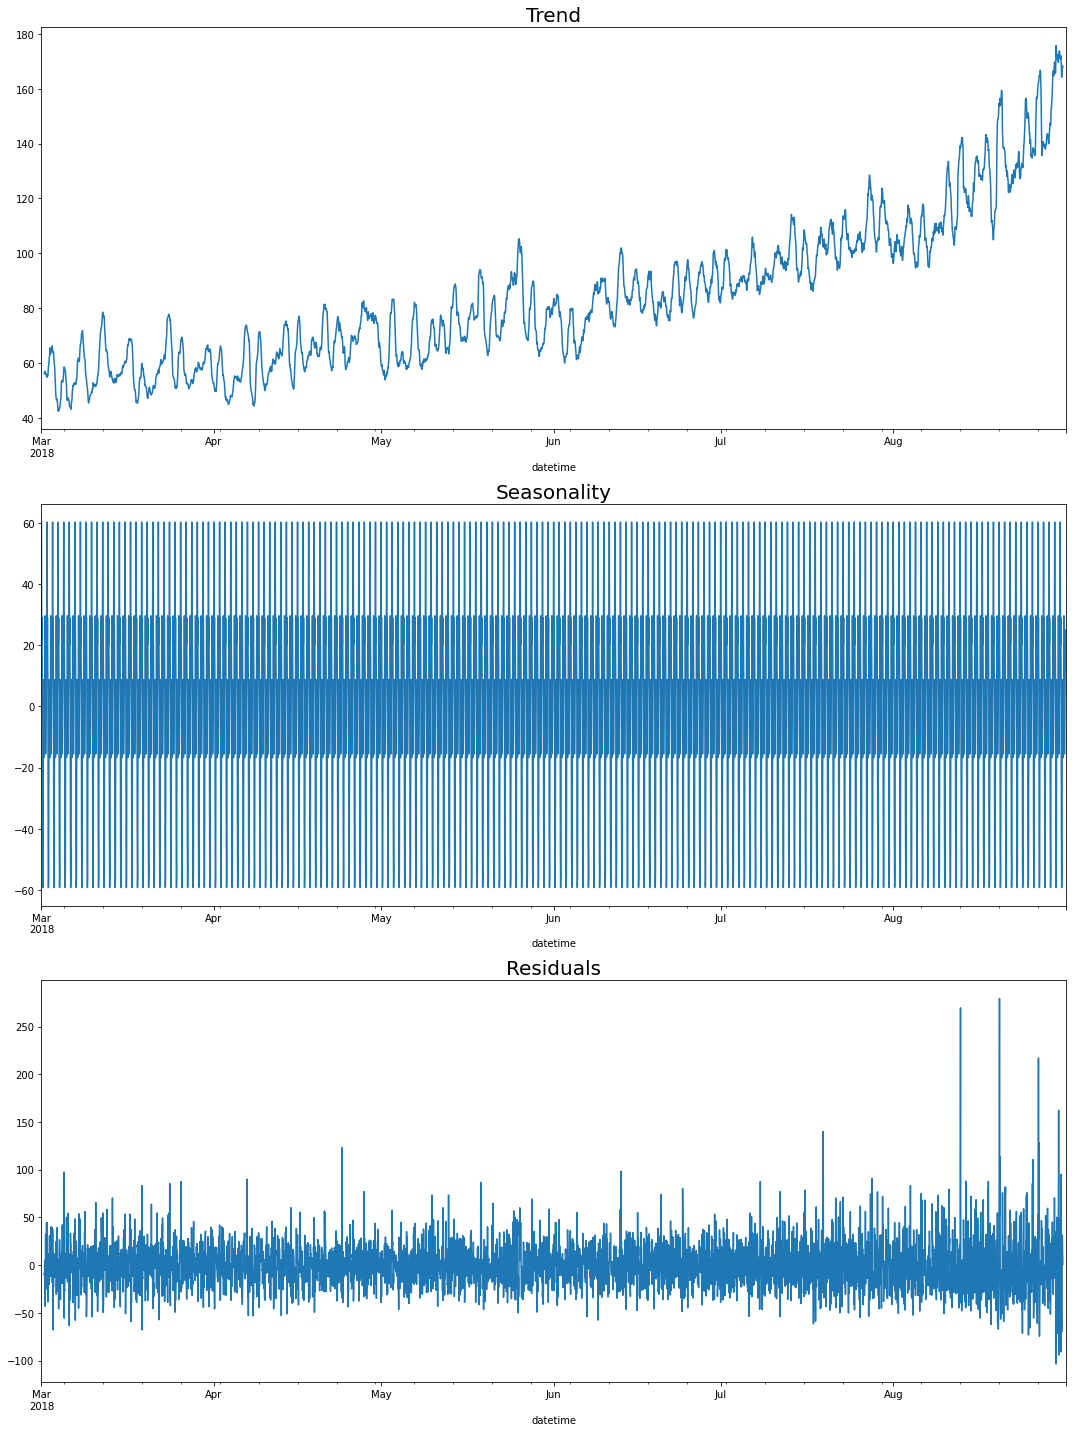

In [9]:
plt.figure(figsize=(15, 20))  

plt.subplot(311) 
seasonal_decompose(df['num_orders']).trend.plot(ax=plt.gca())  
plt.title('Trend', fontsize=20)  

plt.subplot(312)  
seasonal_decompose(df['num_orders']).seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality', fontsize=20)  

plt.subplot(313)  
seasonal_decompose(df['num_orders']).resid.plot(ax=plt.gca())  
plt.title('Residuals', fontsize=20) 

plt.tight_layout();

Tendencia: oscilan entre 40 y 180 y los servicios de la compañia suben con el tiempo

Estacionalidad: es no estacionaria.

Residuos: Se observa que los datos ruido sufren un incrementeo importante a partir del mes de agosto.

## Formación

Ahora se crean una función que se encarga de crear características adicionales para un horizonte de pronóstico de un paso, crando características de desfase para capturar las relaciones temporales entre observaciones pasadas y presentes, y la media móvil con el fin de suavizar la serie temporal y poder capturar tendencias a largo plazo.

Todo lo anterior con el fin de proceder al entrenamientos de modelos que nos lleven a lograr el objetivo buscado.

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hourofday'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
        
    df['rolling_std'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).std()
    )


make_features(df, 7, 10)

In [11]:
df

,num_orders,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,173.3,35.267391
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,166.6,35.362252
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,162.9,34.449480


Se observa la suabización que tuvo rolling en nuestros datos y que la desviación estandar aumenta después de agosto, lo que nos indica una mayor variabilidad en los datos a lo largo del tiempo.

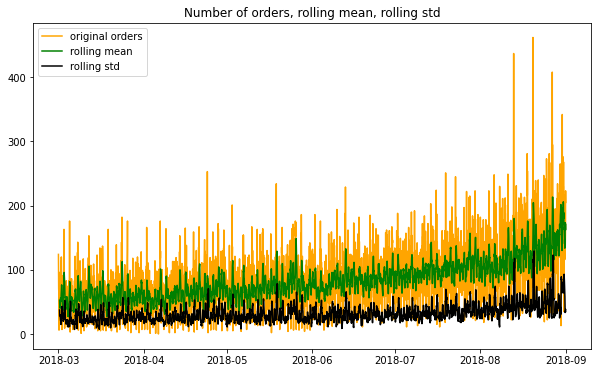

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(df['num_orders'], color ='orange', label="original orders")
plt.plot(df['rolling_mean'], color ='green', label="rolling mean")
plt.plot(df['rolling_std'], color ='black', label="rolling std")
plt.title('Number of orders, rolling mean, rolling std')
plt.legend(loc='best')
plt.show()

Separación de datos y eliminación de NaN

In [13]:
df = df.dropna(how='any', axis=0)

features = df.drop('num_orders',axis=1)
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

print('Periodo para el set de entrenamiento:', features_train.index.min(), 'a', features_train.index.max())
print('\nPeriodo para el set de prueba:', features_test.index.min(), 'a', features_test.index.max())

Periodo para el set de entrenamiento: 2018-03-01 10:00:00 a 2018-08-13 14:00:00

Periodo para el set de prueba: 2018-08-13 15:00:00 a 2018-08-31 23:00:00


Se escalan las características previo al modelado.

In [14]:
sc = StandardScaler()
features_train = sc.fit_transform(features_train)
features_test = sc.transform(features_test)

Se inicializa 'TimeSeriesSplit' que se utiliza para diferentes modelos para dividir el conjunto de entrenamiento en partes de entrenamiento y validación.

In [15]:
tscv = TimeSeriesSplit()

# Modelos

**Random Forest**

In [16]:
model_rfr = RandomForestRegressor(random_state = 12345)
param_grid = {'n_estimators': [2,5,10,15],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10]}

grid_search_rfr = GridSearchCV(estimator = model_rfr, param_grid = param_grid, cv = tscv, scoring= 'neg_root_mean_squared_error')
grid_search_rfr.fit(features_train, target_train)

best_estimator_rfr = grid_search_rfr.best_estimator_
print(best_estimator_rfr)


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=15,
                      random_state=12345)


**XGBoost**

In [17]:
model_xgb = XGBRegressor(random_state=12345)
param_grid_xgb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5]}

grid_search_xgb = GridSearchCV(estimator = model_xgb, param_grid = param_grid_xgb, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid_search_xgb.fit(features_train, target_train)

best_estimator_xgb = grid_search_xgb.best_estimator_
print(best_estimator_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


**Light Gradient Boosting Machine**

In [18]:
model_lgbm = LGBMRegressor(random_seed=12345)
param_lgbm = {'num_leaves':[10, 15, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 30], 'objective':['rmse']}

grid_search_lgbm = GridSearchCV(estimator = model_lgbm, param_grid = param_lgbm, cv = tscv, n_jobs=-1, scoring = 'neg_root_mean_squared_error')
grid_search_lgbm.fit(features_train, target_train)

best_estimator_lgbm = grid_search_lgbm.best_estimator_
print(best_estimator_lgbm)

LGBMRegressor(n_estimators=30, num_leaves=20, objective='rmse',
              random_seed=12345)


**CatBoost**

In [19]:
model_cb = CatBoostRegressor(random_seed=12345, verbose=0)
param_cb = {'depth':[4, 6, 8, 10], 'learning_rate':[0.5, 0.1], 'iterations':[10, 30, 50, 100], 'loss_function':['RMSE']}

grid_search_cb = GridSearchCV(estimator = model_cb, param_grid = param_cb, cv = tscv, n_jobs=-1, scoring = 'neg_root_mean_squared_error')
grid_search_cb.fit(features_train, target_train)

best_estimator_cb = grid_search_cb.best_estimator_
print(best_estimator_cb)

print(abs(grid_search_cb.best_score_))

25.356706485620734


## Prueba

**Random Forest**

In [20]:
predictions_rfr = best_estimator_rfr.predict(features_test)

rmse_rfr = np.sqrt(mean_squared_error(target_test, predictions_rfr))
print("RMSE para RandomForestRegressor:", rmse_rfr)

RMSE para RandomForestRegressor: 49.47567878592594


**XGBoost**

In [21]:
predictions_xgb = best_estimator_xgb.predict(features_test)

rmse_xgb = np.sqrt(mean_squared_error(target_test, predictions_xgb))
print("RMSE para XGBoost:", rmse_xgb)

RMSE para XGBoost: 45.76447597575049


**Light Gradient Boosting Machine**

In [22]:
# Hacer predicciones en los datos de prueba
predictions_lgbm = best_estimator_lgbm.predict(features_test)

# Calcular el RMSE
rmse_lgbm = np.sqrt(mean_squared_error(target_test, predictions_lgbm))
print("RMSE para LightGBM:", rmse_lgbm)

RMSE para LightGBM: 48.06889296307389


**CatBoost**

In [23]:
# Hacer predicciones en los datos de prueba
predictions_catboost = best_estimator_cb.predict(features_test)

# Calcular el RMSE
rmse_catboost = np.sqrt(mean_squared_error(target_test, predictions_catboost))
print("RMSE para CatBoost:", rmse_catboost)

RMSE para CatBoost: 45.81720916103631


In [24]:
models = pd.DataFrame({
    'Model': ['Random_Forest', 'XGBoost', 'Light_GBM', 'CatBoost'],
    'Score': [rmse_rfr, rmse_xgb, rmse_lgbm, rmse_catboost]})
sorted_by_score = models.sort_values(by='Score', ascending=False)

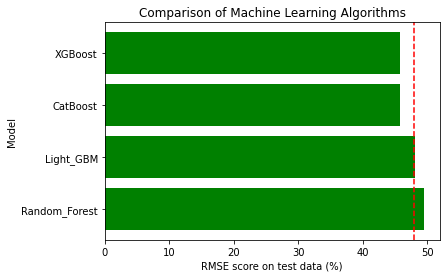

In [25]:
plt.barh(sorted_by_score['Model'], sorted_by_score['Score'], color='green')
plt.axvline(x=48, color='red', linestyle='--')
plt.title('Comparison of Machine Learning Algorithms')
plt.xlabel('RMSE score on test data (%)')
plt.ylabel('Model')
plt.show()

# Conclusión

Con el objetivo de encontrar el mejor modelo para predecir la solicitud de servicios de taxi en el aeropuerto, se trabaja con la información proporcionada por la compañía.

Se realiza un escrutinio de los datos y las adecuaciones necesarias para trabajar con ellos en un esquema de series temporales.

Durante el Análisis Exploratorio de Datos, se observa una tendencia general de crecimiento en el número de pedidos a lo largo del tiempo. No se detecta ninguna estacionalidad clara, pero esto podría entenderse considerando que los datos se recopilaron durante solo 6 meses.

Para trabajar con los distintos modelos, se dividen los datos en conjuntos de entrenamiento y prueba en una proporción de 1:5, y se estandarizan las escalas de los datos.

Se comparan los resultados de los modelos Random Forest, XGBoost, LightGBM y CatBoost, los cuales se ejecutan utilizando una grilla de optimización de hiperparámetros.

Con la premisa de que el modelo propuesto no debe arrojar un RMSE mayor a 48 en su conjunto de prueba, se propone el uso de los modelos **XGBoost** y **CatBoost**.